In [1]:
from PIL import Image
import torch

In [2]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import matplotlib.pyplot as plt

class CellDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "img"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "groundtruth"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "img", self.imgs[idx])
        mask_path = os.path.join(self.root, "groundtruth", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [4]:
dataset = CellDataset('../data/augmented/', get_transform(train=True))
dataset_test = CellDataset('../data/augmented/', get_transform(train=False))

In [5]:
img, _ = dataset_test[12]
print(img.shape)

torch.Size([3, 360, 360])


In [6]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(360),
    transforms.ToTensor()
])

In [7]:
img = Image.open('res.jpeg').convert('RGB')
img = transform(img)

In [8]:
PATH = "../../net/entire_model_10_03_01.pt"
net = torch.load(PATH, map_location=torch.device('cpu'))

In [9]:
net.eval()
with torch.no_grad():
    prediction = net([img])

In [44]:
import random
import cv2

def show_detected_masks(in_image, pred, score):
    x = []
    y = []
    in_img = in_image.mul(255).permute(1, 2, 0).byte().numpy()
    for i in range(len(pred[0]['masks'])):
        msk=pred[0]['masks'][i,0].detach().cpu().numpy()
        scr=pred[0]['scores'][i].detach().cpu().numpy()
        
        if scr>score:
            in_img[:,:,0][msk>0.5] = random.randint(0,255)
            in_img[:, :, 1][msk > 0.5] = random.randint(0,255)
            in_img[:, :, 2][msk > 0.5] = random.randint(0, 255)

            M = cv2.moments(msk)
            x.append(int(M["m10"] / M["m00"]))
            y.append(int(M["m01"] / M["m00"]))
    return Image.fromarray(in_image.mul(255).permute(1, 2, 0).byte().numpy()), in_img, x, y
    

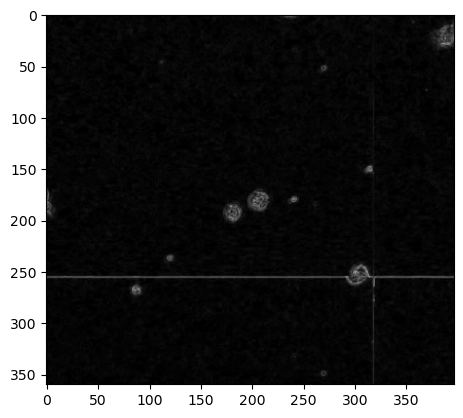

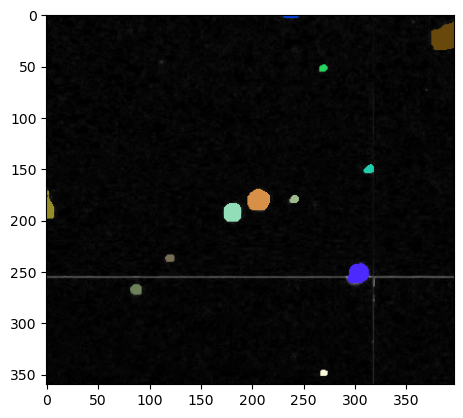

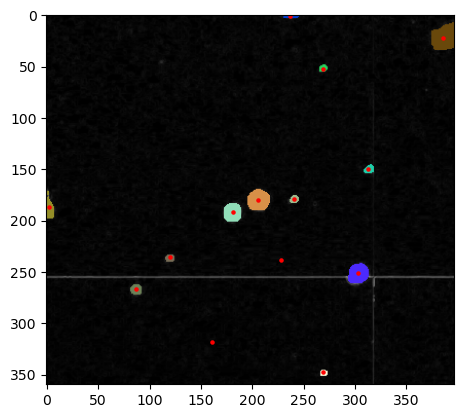

In [48]:
orig_img, masks, mx,my = show_detected_masks(img, prediction, 0.5)
plt.imshow(orig_img)
plt.show()

plt.imshow(masks)
plt.show()

plt.imshow(masks)
plt.scatter(mx,my, c='r', s =5)
